==46==
매개변수 갱신 작업(갱신 코드)를 모듈화하고 다른 모듈로 대체할 수 있는 코드 만들기

**Optimizer클래스**
매개변수 갱신을 위한 기반 클래스.

In [1]:
# # setup 메서드는 매개변수를 갖는 클래스를 인스턴스 변수인 target으로 설정
# def setup(self, target):
#         self.target = target
#         return self

# #update 메서드는 모든 매개변수를 갱신
# def update(self):
#         params = [p for p in self.target.params() if p.grad is not None]

#         for f in self.hooks:
#             f(params)

#         for param in params:
#             self.update_one(param)

# # SGD 클래스
# # 경사하강법으로 매개변수를 갱신
# # __init__메서드는 학습률을 받아 초기화
# #update_one메서드에서 매개변수 갱신 코드를 구현
# class SGD(Optimizer):
#     def __init__(self, lr=0.01):
#         super().__init__()
#         self.lr = lr

#     def update_one(self, param):
#         param.data -= self.lr * param.grad.data


In [2]:
# SGD 클래스를 사용한 문제해결
from dezero import optimizers

# model = MLP((hidden_size, 1)) #MLP클래스를 사용하여 모델을 생성
# optimizer = Optimizers.SGD(lr).setup(model)

# optimizer.update() #SGD클래스로 매개변수를 갱신

#SGD 이외의 최적화 기법
기울기를 이용한 최적화 기법
-Momentum, AdaGrad, AdaDelta, Adam
-Optimizer클래스를 이용하고 상속하여 최적화 기법을 필요에 따라 전환하거나 구현.
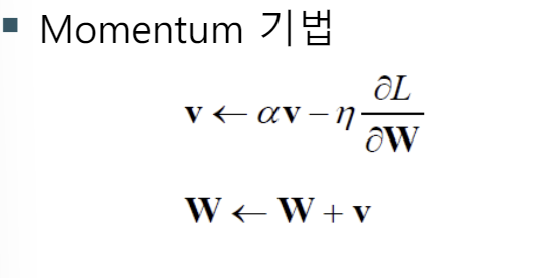

W는 갱신할 가중치 매개변수,v는 속도, 𝜕𝐿/𝜕W는 기울기,  η는 학습률
αv는 아무런 힘을 받지않을 때 서서히 감속시키는 역할


In [3]:
# #MomentumSGD 구현 코드
# #속도에 해당하는 데이터, 딕셔너리 타임의 인스턴스 변수 self.vs에 유지
# #초기화 시에는 vs에 아무것도 담겨있지 않다.

# class MomentumSGD(Optimizer):
#     def __init__(self, lr=0.01, momentum=0.9):
#         super().__init__()
#         self.lr = lr
#         self.momentum = momentum
#         self.vs = {} 

#     def update_one(self, param):
#         v_key = id(param)
#         if v_key not in self.vs:
#             xp = cuda.get_array_module(param.data)
#             self.vs[v_key] = xp.zeros_like(param.data)

#         v = self.vs[v_key]
#         v *= self.momentum
#         v -= self.lr * param.grad.data
#         param.data += v

==47==
다중 클래스 분류
-여러 클래스로 분류하는 문제
-분류 대상이 여러가지 클래스 중 어디에 속하는지 추정

In [4]:
# 슬라이스 조작 함수
# Variable의 다차원 배열 중에서 일부를 슬라이스하여 뽑아준다.
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1,2,3],[4,5,6]]))
y = F.get_item(x,1) #(2,3)형상의 x에서 1번째 행의 원소 추출
print(y)

variable([4 5 6])


In [5]:
#다차원 배열의 일부를 추출하는 작업
#get_item 함수 사용시 같은 인덱스를 반복 지정하여 동일원소 여러번 뺄 수 있다.
x = Variable(np.array([[1,2,3],[4,5,6]]))
indices = np.array([0,0,1])
y = F.get_item(x,indices)
print(y)

variable([[1 2 3]
          [1 2 3]
          [4 5 6]])


In [6]:
# 특수 메서드로 설정
# get_item함수를 Variable메서드로 사용함.
# 슬라이스 작업의 역전파도 이뤄진다.

Variable.__getitem__ = F.get_item
y = x[1]
print(y)

y = x[: , 2]
print(y)

variable([4 5 6])
variable([3 6])


In [7]:
# 소프트맥스 함수
## 신경망으로 다중 클래스 분류
# 선형회귀 때 이용한 신경망 & MLP 클래스로 구현해둔 신경망을 그대로 이용할 수 있다.

from dezero.models import MLP
model = MLP((10,3)) # 2층으로 이뤄진 완전연결 신경망을 만들어준다 >>  원소가 3개인 3차원 벡터로 변환

x = np.array([[0.2, -0.4]]) #x의 형상은 (1,2) > 원소가 2개인 2차원 벡터
y = model(x)
print(y) #값이 가장 큰 원소의 인덱스가 이 모델이 분류한 클래스. > 2번 원소가 크기때문에 2번 클래스로 분류

variable([[ 0.3871487  -0.50755447 -1.40892602]])


In [8]:
from dezero import Variable, as_variable
import dezero.functions as F

#소프트맥스 함수의 입력 𝑦k가 총 n개라고 가정
#exp(yk)는 입력 yk의 지수함수
def softmax1d(x):
    x = as_variable(x)
    y = F.exp(x)
    sum_y = F.sum(y)
    return y / sum_y

x = Variable(np.array([[0.2, -0.4]]))
y = model(x)
p = softmax1d(y)
print(y)
print(p)

variable([[ 0.3871487  -0.50755447 -1.40892602]])
variable([[0.6350505 0.2595635 0.105386 ]])


In [9]:
# 배치batch데이터에서도 소프트맥스 함수를 적용할 수 있다.
# 샘플 데이터 각각에 소프트맥스 함수를 적용

# def softmax_simple(x, axis=1): # 인수 x는 2차원 데이터로 가정
#     x = as_variable(x)
#     y = exp(x)
#     sum_y = sum(y, axis=axis, keepdims=True) # True이므로 각 행에서 나눗셈이 이뤄진다.
#     return y / sum_y

# 선형 회귀에선 손실 함수로 평균 제곱 오차를 이용.
# 다중 클래스 분류에 적합한 손실함수는 "교차 엔트로피 오차"를 이용.

-정답 데이터의 원손느 정답에 해당하는 클래스면 1로, 그렇지 않으면 0으로
-표현 방식을 원핫 벡터라한다.
-pk는 신경망에서 소프트맥스 함수를 적용한 후의 출력
-정답 클래스에 해당하는 번호의 확률 p를 추출함으로써 교차 엔트로피의 오차를 계산
-P[t]는 벡터 p에서 t번째 요소만을 추출


In [10]:
# def softmax_cross_entropy_simple(x, t):
#     x, t = as_variable(x), as_variable(t) #x는 신경망에서 소프트맥스 함수 적용 전의 출력, t는 정답 데이터
#     N = x.shape[0]

#     p = softmax(x) # 또는 softmax_simple(x)
#     p = clip(p, 1e-15, 1.0)  # log(0)을 방지하기 위해 p의 값을 1e-15 이상으로
#     log_p = log(p) #log는 Dezero함수
#     tlog_p = log_p[np.arange(N), t.data]
#     y = -1 * sum(tlog_p) / N
#     return y

In [11]:
#다중 클래스 분류를 하는 신경망에 구체적인 데이터를 주어 교차 엔트로피 오차 계산
x = np.array([[0.2, -0.4],[0.3,0.5],[1.3,-3.2],[2.1,0.3]])
t = np.array([2, 0, 1, 0])
y = model(x)
loss = F.softmax_cross_entropy_simple(y,t) # 혹은 F.softmax_cross_entropy(y,t) # 손실함수 계산
print(loss)

variable(1.201275546926755)


==48==
다중 클래스 분류 수행
-소프트맥스 함수와 교차 엔트로피 오차를 구현
-스파이럴 데이터셋(나선형or소용돌이 모양)이라는 작은 데이터셋을 사용하여 다중 클래스 분류 실제 수행

In [12]:
import dezero.datasets as ds
x, t = ds.get_spiral(train = True)
print(x.shape)
print(t.shape)

print(x[10], t[10])
print(x[110], t[110])

(300, 2)
(300,)
[-0.12995958 -0.00324155] 1
[ 0.3282343  -0.54941994] 0


미니배치: 데이터가 많을 때는 조금씩 무작위로 모아서 처리 이때의 '데이터 뭉치'

In [21]:
import math
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP
import numpy as np
# 하이퍼파라미터 생성(사람이 결정하는 매개변수, 은닉층 수와 학습률 등이 여기 속함)
max_epoch = 300 # 에포크는 일종의 단위 (준비된 데이터셋 모두 사용시 1에포크)
batch_size = 30 # 데이터를 한번에 30개씩 묶어 처리
hidden_size = 10
lr = 1.0

#데이터 읽기/ 모델, 옵티마이저 생성
x, t = dezero.datasets.get_spiral(train=True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(x)
max_iter = math.ceil(data_size / batch_size)


for epoch in range(max_epoch):
    # 데이터셋의 인덱스 뒤섞기
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        # 미니배치 생성
        batch_index = index[i * batch_size:(i + 1) * batch_size]
        batch_x = x[batch_index]
        batch_t = t[batch_index]

        # 기울기 산출/ 매개변수 갱신
        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(batch_t)

    # 에포크마다 학습 경과 출력
    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

epoch 1, loss 1.13
epoch 2, loss 1.05
epoch 3, loss 0.95
epoch 4, loss 0.92
epoch 5, loss 0.87
epoch 6, loss 0.89
epoch 7, loss 0.84
epoch 8, loss 0.78
epoch 9, loss 0.80
epoch 10, loss 0.79
epoch 11, loss 0.78
epoch 12, loss 0.76
epoch 13, loss 0.77
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.77
epoch 17, loss 0.78
epoch 18, loss 0.74
epoch 19, loss 0.74
epoch 20, loss 0.72
epoch 21, loss 0.73
epoch 22, loss 0.74
epoch 23, loss 0.77
epoch 24, loss 0.73
epoch 25, loss 0.74
epoch 26, loss 0.74
epoch 27, loss 0.72
epoch 28, loss 0.72
epoch 29, loss 0.72
epoch 30, loss 0.73
epoch 31, loss 0.71
epoch 32, loss 0.72
epoch 33, loss 0.72
epoch 34, loss 0.71
epoch 35, loss 0.72
epoch 36, loss 0.71
epoch 37, loss 0.71
epoch 38, loss 0.70
epoch 39, loss 0.71
epoch 40, loss 0.70
epoch 41, loss 0.71
epoch 42, loss 0.70
epoch 43, loss 0.70
epoch 44, loss 0.70
epoch 45, loss 0.69
epoch 46, loss 0.69
epoch 47, loss 0.71
epoch 48, loss 0.70
epoch 49, loss 0.69
epoch 50, loss 0.69
epoch 51,

코드 실행 후 손실 그래프

-학습을 진행할수록 손실이 줄어든다
-딥러닝의 특징은 층을 더 깊게 쌓는 식으로 표현력을 키울 수 있다.

==49==

대규모 데이터셋 처리
-스파이럴 데이터셋은 작은 데이터셋이라서 ndarray 인스턴스 하나로 처리
-Dataset클래스에는 데이터를 전처리할 수 있는 구조도 추가

In [14]:
#Dataset클래스는 기반 클래스로서의 역할을 한다.
#실제로 사용하는 데이터셋은 이를 상속하여 구현
# class Dataset:
#     def __init__(self, train=True):
#         self.train = train
#         self.data = None
#         self.label = None
#         self.prepare()

#     def __getitem__(self, index): #단순히 지정된 인덱스에 위치하는 데이터를 꺼낸다.
#         assert np.isscalar(index) #index는 정수만 지원
#         if self.label is None:
#             return self.transform(self.data[index]), None
#         else:
#             return self.transform(self.data[index])

#     def __len__(self): #데이터셋의 길이를 알려준다.
#         return len(self.data)

#     def prepare(self):
#         pass

In [15]:
# class Spiral(Dataset):
#     def prepare(self):
#         self.data, self.label = get_spiral(self.train)
# >>데이터 추출할 수 있다.

In [16]:
import numpy as np
import dezero

train_set = dezero.datasets.Spiral(train=True)
print(train_set[0])
print(len(train_set))

(array([-0.13981389, -0.00721657], dtype=float32), 1)
300


In [17]:
# **큰 데이터셋 처리**
# 작은 데이터셋은 Dataset클래스의 인스턴스 변수인 data와 label에 직접 ndarray 인스턴스를 유지해도 무리가 없다.
## 빅데이터 처리 방법
    # BigData 클래스를 초기화할 때는 데이터를 읽지 않는다.
    # 데이터에 접근하는 __getitem__(index)가 불리는 시점에 데이터를 읽는다.
# class Bigdata(Dataset):
#     def __getitem__(index):
#         x = np.load('data/[].npy'.format(index))
#         t = np.load('label/[].npy'.format(index))
#         return x,t
#     def __len__():
#         return 1000000

In [18]:
#데이터 이어 붙이기

#신경망 입력 형태로의 데이터를 준비
#인덱스를 지정하여 batch에 여러 데이터가 리스트로 저장하고 ndarray 인스턴스로 변환

import dezero.datasets


train_set = dezero.datasets.Spiral()

#batch의 각 원소에서 데이터만을 꺼내 하나의 ndarray 인스턴스로 변형함(이어붙임)
batch_index = [0,1, 2]
batch = [train_set[i] for i in batch_index]

x = np.array([example[0] for example in batch])
t = np.array([example[1] for example in batch])

print(x.shape)
print(t.shape)

(3, 2)
(3,)


In [19]:
import math
import numpy as np
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero.models import MLP


max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

#Spiral을 BigData로 교체하는 것만으로 훨씬 큰 데이터셋을 대응할 수 있음.
train_set = dezero.datasets.Spiral()
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(train_set)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    # Shuffle index for data
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        # 미니배치 꺼내기
        batch_index = index[i * batch_size:(i + 1) * batch_size]
        batch = [train_set[i] for i in batch_index]
        batch_x = np.array([example[0] for example in batch])
        batch_t = np.array([example[1] for example in batch])

        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(batch_t)

    # 에포크마다 손실 출력
    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

epoch 1, loss 1.13
epoch 2, loss 1.05
epoch 3, loss 0.95
epoch 4, loss 0.92
epoch 5, loss 0.87
epoch 6, loss 0.89
epoch 7, loss 0.84
epoch 8, loss 0.78
epoch 9, loss 0.80
epoch 10, loss 0.79
epoch 11, loss 0.78
epoch 12, loss 0.76
epoch 13, loss 0.77
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.77
epoch 17, loss 0.78
epoch 18, loss 0.74
epoch 19, loss 0.74
epoch 20, loss 0.72
epoch 21, loss 0.73
epoch 22, loss 0.74
epoch 23, loss 0.77
epoch 24, loss 0.73
epoch 25, loss 0.74
epoch 26, loss 0.74
epoch 27, loss 0.72
epoch 28, loss 0.72
epoch 29, loss 0.72
epoch 30, loss 0.73
epoch 31, loss 0.71
epoch 32, loss 0.72
epoch 33, loss 0.72
epoch 34, loss 0.71
epoch 35, loss 0.72
epoch 36, loss 0.71
epoch 37, loss 0.71
epoch 38, loss 0.70
epoch 39, loss 0.71
epoch 40, loss 0.70
epoch 41, loss 0.71
epoch 42, loss 0.70
epoch 43, loss 0.70
epoch 44, loss 0.70
epoch 45, loss 0.69
epoch 46, loss 0.69
epoch 47, loss 0.71
epoch 48, loss 0.70
epoch 49, loss 0.69
epoch 50, loss 0.69
epoch 51,

In [20]:
# # 데이터셋 전처리
# # 모델에 데이터를 입력하기 전에 데이터를 특정한 형태로 가공할 경우가 많다.
# # 초기화 시에는 transform과 target_transform을 새롭게 받는다.
# # transform은 입력 데이터 하나에 대한 변환 처리, target_transform 레이블 하나에 대한 변환 처리

# class Dataset:
#     def __init__(self, train=True, transform=None, target_transform=None):
#         self.train = train
#         self.transform = transform
#         self.target_transform = target_transform
#         if self.transform is None:
#             self.transform = lambda x: x
#         if self.target_transform is None:
#             self.target_transform = lambda x: x

#         self.data = None
#         self.label = None
#         self.prepare()

#     def __getitem__(self, index):
#         assert np.isscalar(index)
#         if self.label is None:
#             return self.transform(self.data[index]), None
#         else:
#             return self.transform(self.data[index]),\
#                     self.target_transform(self.label[index])

#     def __len__(self):
#         return len(self.data)

#     def prepare(self):
#         pass
